In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cpu


In [2]:
n_days = 220
dates = pd.date_range("2025-08-01", periods=n_days, freq="D")

trend = np.linspace(30, 90, n_days)
weekly = 10 * np.sin(2 * np.pi * np.arange(n_days) / 7)
noise = np.random.normal(0, 4, n_days)

sales = np.maximum(0, trend + weekly + noise)

df = pd.DataFrame({"date": dates, "sales": sales})


In [3]:
y = df["sales"].astype(float).values
split = int(len(y) * 0.8)

train = y[:split]
test  = y[split:]


In [4]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.reshape(-1,1)).astype(np.float32)
test_scaled  = scaler.transform(test.reshape(-1,1)).astype(np.float32)

NOISE_STD = 0.05
train_noisy = train_scaled + NOISE_STD * np.random.randn(*train_scaled.shape)
train_noisy = np.clip(train_noisy, 0, 1)


In [5]:
class DAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

dae = DAE().to(device)
optimizer = torch.optim.Adam(dae.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [7]:
dae = dae.to(device)

X_noisy = torch.from_numpy(train_noisy).float().to(device)   # ✅ float32
X_clean = torch.from_numpy(train_scaled).float().to(device)  # ✅ float32


EPOCHS = 30
dae.train()

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    recon = dae(X_noisy)
    loss = criterion(recon, X_clean)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1} | DAE Loss: {loss.item():.6f}")


Epoch 5 | DAE Loss: 0.376899
Epoch 10 | DAE Loss: 0.251544
Epoch 15 | DAE Loss: 0.165699
Epoch 20 | DAE Loss: 0.103178
Epoch 25 | DAE Loss: 0.056690
Epoch 30 | DAE Loss: 0.031425


In [8]:
dae.eval()
with torch.no_grad():
    train_denoised = dae(X_clean).cpu().numpy()


In [9]:
LOOKBACK = 30

def make_sequences(arr, lookback):
    X, y = [], []
    for i in range(lookback, len(arr)):
        X.append(arr[i-lookback:i, 0])
        y.append(arr[i, 0])
    X = np.array(X, dtype=np.float32)[:, :, None]
    y = np.array(y, dtype=np.float32)[:, None]
    return X, y

X_train, y_train = make_sequences(train_denoised, LOOKBACK)


In [10]:
class LSTMForecast(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMForecast().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [11]:
dataset = DataLoader(
    list(zip(torch.from_numpy(X_train), torch.from_numpy(y_train))),
    batch_size=32,
    shuffle=True
)

EPOCHS = 25
model.train()

for epoch in range(EPOCHS):
    losses = []
    for xb, yb in dataset:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        yhat = model(xb)
        loss = criterion(yhat, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1} | LSTM Loss: {np.mean(losses):.6f}")


Epoch 5 | LSTM Loss: 0.010108
Epoch 10 | LSTM Loss: 0.002413
Epoch 15 | LSTM Loss: 0.002210
Epoch 20 | LSTM Loss: 0.002181
Epoch 25 | LSTM Loss: 0.002198


In [12]:
model.eval()
window = train_denoised[-LOOKBACK:].copy()
preds = []

for _ in range(len(test)):
    X = torch.from_numpy(window.reshape(1, LOOKBACK, 1)).to(device)
    with torch.no_grad():
        yhat = model(X).cpu().numpy()[0,0]
    preds.append(yhat)
    window = np.vstack([window[1:], [[yhat]]])

pred = scaler.inverse_transform(np.array(preds).reshape(-1,1)).reshape(-1)


In [13]:
mae  = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
mape = np.mean(np.abs((test - pred) / np.maximum(test, 1e-8))) * 100

print("DAE + LSTM Metrics")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


DAE + LSTM Metrics
MAE  : 32.53
RMSE : 33.64
MAPE : 37.52%


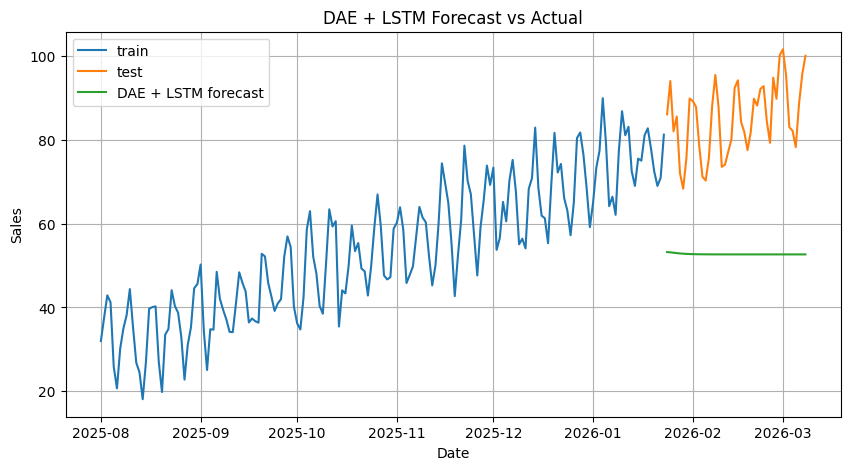

In [14]:
plt.figure(figsize=(10,5))
plt.plot(df["date"][:split], train, label="train")
plt.plot(df["date"][split:], test, label="test")
plt.plot(df["date"][split:], pred, label="DAE + LSTM forecast")
plt.title("DAE + LSTM Forecast vs Actual")
plt.xlabel("Date"); plt.ylabel("Sales")
plt.legend(); plt.grid(True)
plt.show()
